# Cliquet
Price a Cliquet using different models. Cliquets are frequently used as hedges for annuities with caps and floors.
For a definition of the payoff, and the dataclass to construct a cliquet timetable, see [qablet_contracts.eq.cliquet.Accumulator](https://qablet.github.io/qablet-contracts/examples/equity_cliquet)

In [1]:
import pandas as pd
from finmc.models.heston import HestonMC
from qablet.base.mc import MCPricer
from qablet_contracts.eq.cliquet import Accumulator

from data.spx_2005_09_15 import (
    basic_info,
    heston_data,
    localvol_data,
    rbergomi_data,
)
from src.model.localvol import LVMC
from src.model.rbergomi import rBergomiMC

### Contract
Create a Cliquet Contract fixing bi-monthly.

In [2]:
info = basic_info()
prc_dt = info["prc_dt"]
exp_dt = prc_dt + pd.DateOffset(years=1)

fix_dates = pd.bdate_range(prc_dt, exp_dt, freq="2BME")
global_floor = 0.0
local_floor = -0.03
local_cap = 0.05
timetable = Accumulator(
    "USD",
    "SPX",
    fix_dates,
    global_floor,
    local_floor,
    local_cap,
    state={"S_PREV": 1.0},
).timetable()

print(timetable["events"].to_pandas())

                       time   op  quantity    unit track
0 2005-09-30 00:00:00+00:00  NaN       0.0   start   NaN
1 2005-11-30 00:00:00+00:00  NaN       0.0  addfix   NaN
2 2006-01-31 00:00:00+00:00  NaN       0.0  addfix   NaN
3 2006-03-31 00:00:00+00:00  NaN       0.0  addfix   NaN
4 2006-05-31 00:00:00+00:00  NaN       0.0  addfix   NaN
5 2006-07-31 00:00:00+00:00  NaN       0.0  addfix   NaN
6 2006-07-31 00:00:00+00:00    >       0.0     USD      
7 2006-07-31 00:00:00+00:00    +     100.0     ACC      


### Compare Models
Compare different models, starting with Local Volatility Model.

In [3]:
model = MCPricer(LVMC)
price, _ = model.price(timetable, localvol_data())
print(f"Localvol price: {price}")

Localvol price: 8.362579783522644


Heston Model

In [4]:
model = MCPricer(HestonMC)
price, _ = model.price(timetable, heston_data())
print(f"Heston price: {price}")

Heston price: 8.582766050939771


Bergomi Model

In [5]:
model = MCPricer(rBergomiMC)
dataset = rbergomi_data()
dataset["MC"]["PATHS"] = 20_000  # very slow with 100_000, 1/250
price, _ = model.price(timetable, dataset)
print(f"rBergomi price: {price}")

rBergomi price: 9.026120269810775


Create a series of cliques with different global floors.

In [6]:
timetables = []
notional = 100
global_floors = [gf * notional for gf in [-0.02, 0.0, 0.02, 0.04]]
for global_floor in global_floors:
    timetable = Accumulator(
        "USD",
        "SPX",
        fix_dates,
        global_floor,
        local_floor,
        local_cap,
        notional=notional,
        state={"S_PREV": 1.0},
    ).timetable()
    timetables.append(timetable)
df = pd.DataFrame({"global floor": global_floors})

In [7]:
model = MCPricer(LVMC)

prices = []
for timetable in timetables:
    price, _ = model.price(timetable, localvol_data())
    prices.append(price)

df["LocalVol"] = prices
df

,global floor,LocalVol
0,-2.0,8.195597
1,0.0,8.326067
2,2.0,8.563759
3,4.0,8.960705


In [8]:
model = MCPricer(HestonMC)

prices = []
for timetable in timetables:
    price, _ = model.price(timetable, heston_data())
    prices.append(price)
df["Heston"] = prices
df

,global floor,LocalVol,Heston
0,-2.0,8.195597,8.467444
1,0.0,8.326067,8.573989
2,2.0,8.563759,8.777049
3,4.0,8.960705,9.117914


In [9]:
model = MCPricer(rBergomiMC)
dataset = rbergomi_data()
dataset["MC"]["PATHS"] = 50_000  # very slow with 100_000, 1/250

prices = []
for timetable in timetables:
    price, _ = model.price(timetable, dataset)
    prices.append(price)
df["rBergomi"] = prices
df

,global floor,LocalVol,Heston,rBergomi
0,-2.0,8.195597,8.467444,8.885596
1,0.0,8.326067,8.573989,8.973939
2,2.0,8.563759,8.777049,9.140951
3,4.0,8.960705,9.117914,9.431628


## Plot

<Axes: title={'center': 'Cliquet Prices'}, xlabel='global floor'>

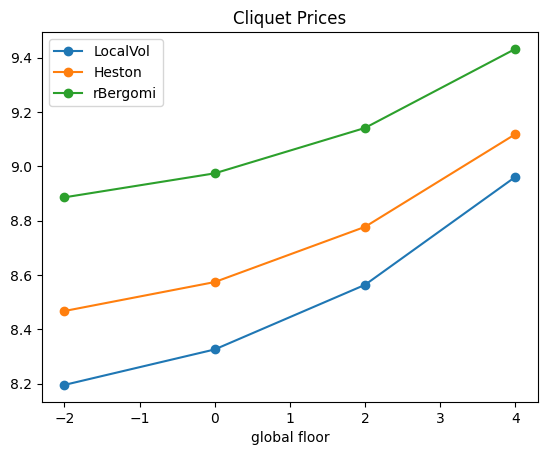

In [10]:
df.columns
df.plot(
    x="global floor",
    y=["LocalVol", "Heston", "rBergomi"],
    marker="o",
    title="Cliquet Prices",
)